# Controllable Sets, Invariant Sets, and MPC Feasibility and Stability

ME C231A, EECS C220B, UC Berkeley

***

In [1]:
# This cell is commented out because Polytope package, Pyomo and solvers are already installed on Docker image.
# Please run this cell only if you are using Google Colab. 

# # install required dependencies
# import sys
# IN_COLAB = 'google.colab' in sys.modules
# if IN_COLAB:
#   !pip install polytope
#   !pip install -q pyomo
#   !apt-get install -y -qq glpk-utils
#   !apt-get install -y -qq coinor-cbc
#   !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
#   !unzip -o -q ipopt-linux64

***

These notes serve the following purposes,

1. Clarify the properties and computation of N-step controllable sets, positive invariant and control invariant sets.
2. Show how invariant sets can be used to design persistently feasible and asymptotically stable MPC controllers.

We will use numerical examples with a second order unstable system
\begin{align}
     x(t+1)= Ax+Bu = \begin{bmatrix} 1.5 & 0 \\ 1 & -1.5  \end{bmatrix} x(t)+
\begin{bmatrix} 1 \\ 0 \end{bmatrix} u(t). \quad \quad \quad \quad (1)
\end{align}

subject to the input and state constraints

\begin{align}
&u(t)\in \mathcal{U}=\left\{u~:~-5\leq u\leq 5\right\},~\forall t\geq 0 \quad \quad \quad \quad \quad \quad \quad \quad (2a)\\
&x(t)\in \mathcal{X}=\left\{x~:~\begin{bmatrix} -10\\-10 \end{bmatrix}  \leq x\leq \begin{bmatrix} 10\\10 \end{bmatrix} \right\},~\forall t\geq 0. \quad \quad \quad \quad (2b)
\end{align}

***

# <font color=blue> 1  Controllable Sets </font>
Recall our definition of $N$-Step Controllable Set $\mathcal{K}_N(\mathcal{S})$.

For a given target set $\mathcal{S}\subseteq \mathcal{X}$, the $N$-step
controllable set $\mathcal{K}_N(\mathcal{S})$ of the system (1)
subject to the constraints (2)
is defined recursively as:

\begin{equation}
\mathcal{K}_j(\mathcal{S}) \triangleq \textbf{Pre}(\mathcal{K}_{j-1}(\mathcal{S}))\cap\mathcal{X},~~ \mathcal{K}_{0}(\mathcal{S})=\mathcal{S},~~~~ j\in\{1,\ldots,N\}  \quad \quad (3)
\end{equation}

All states $x_0$ of the system (1) belonging to the $N$-Step Controllable Set $\mathcal{K}_N(\mathcal{S})$
can be driven, by a suitable control sequence, to the target set $\mathcal{S}$ in $N$ steps, while satisfying input and state constraints.

Note that the computation of the set does not provide the input sequence driving the system states to $\mathcal{S}$.

## 1.1 How to compute $N$-step controllable sets?
From the previous definition we have that a $1$-step controllable set to the set $\mathcal{S}$ is computed as
\begin{equation}
\mathcal{K}_1=\textbf{Pre}(\mathcal{S})\cap\mathcal{X} \quad \quad \quad (4)
\end{equation}
the $2$-step as
\begin{equation}
\mathcal{K}_2=\textbf{Pre}(\mathcal{K}_1)\cap\mathcal{X} \quad \quad \quad (5)
\end{equation}
and so on.
The operation $\textbf{Pre}(\mathcal{K}_1)$ for linear systems subject to linear constraints is discussed in the lecture.
We said that if
\begin{equation}
    \mathcal{S} = \{ x \;|\;  Hx\leq h \}, \quad \mathcal{U} = \{ u  \;|\;  H_u u\leq h_u \}, \quad \quad \quad (6)
\end{equation}
The Pre set is
\begin{equation}
  {\rm Pre}(\mathcal{S}) = \left\{x \in \mathbb{R}^n \,|\, \exists u \in \mathbb{R} \;{\rm s.t.}\;
                              \begin{bmatrix}
                                H A& H B\\
                                0 &H_u
                              \end{bmatrix}
   \begin{pmatrix}
     x \\
     u \\
   \end{pmatrix}
    \leq \begin{bmatrix}
                                h \\
                                h_u
                              \end{bmatrix}\right\}
\end{equation}

which is the projection onto the $x$-space (with dimension $\mathbb{R}^n$) of the polyhedron
\begin{equation}
\mathcal{XU}:= \{\begin{bmatrix}
                                H A& H B\\
                                0 &H_u
                              \end{bmatrix}
   \begin{pmatrix}
     x \\
     u \\
   \end{pmatrix}
    \leq \begin{bmatrix}
                                h \\
                                h_u
                              \end{bmatrix}\}.
\end{equation}

In [2]:
import numpy as np
import scipy.signal
import scipy.linalg
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import polytope as pt

In [3]:
# Unstable System
# x(k+1) = A*x(k) + B*u(k)


A = np.array([[1.5, 0],
               [1, -1.5]])
B = np.array([[1],
               [0]])

# constraints on inputs and states
x1U = 10
x2U = 10
uU = 5

# constraint sets represented as polyhedra
# state constraint
X = pt.Polytope(np.array([[1.0, 0], 
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]), 
                np.array([[x1U], 
                          [x2U],
                          [x1U],
                          [x2U]])) 
# input constraint
U = pt.Polytope(np.array([1, -1]).reshape(2,1),
                np.array([uU, uU]).reshape(2,1))

In [4]:
# Helper Function:

def minkowski_sum(X, Y):

    # Minkowski sum between two polytopes based on 
    # vertex enumeration. So, it's not fast for the
    # high dimensional polytopes with lots of vertices.
    V_sum = []
    if isinstance(X, pt.Polytope):
        V1 = pt.extreme(X)
    else:
        # assuming vertices are in (N x d) shape. N # of vertices, d dimension
        V1 = X
        
    if isinstance(Y, pt.Polytope):
        V2 = pt.extreme(Y)
    else:
        V2 = Y

    for i in range(V1.shape[0]):
        for j in range(V2.shape[0]):
            V_sum.append(V1[i,:] + V2[j,:])
    return pt.qhull(np.asarray(V_sum))


In [5]:
# The operation Pre(S) results in the set of states which evolve into the target set S in one time step. 
def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([])):
        if not B.any():
            return pt.Polytope(Xset.A @ A, Xset.b)
        else:
            tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)

So we can compute $N$-step controllable sets as

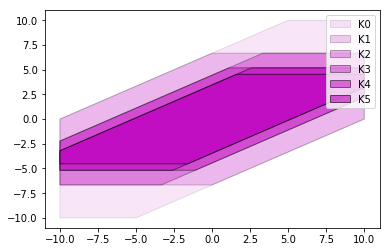

In [6]:
# target set

# eps = 0.001
# S = pt.box2poly([[-eps, eps], [-eps, eps]])

S = X

N = 6  # number of steps
K = {}
PreS = precursor(S, A, U, B)
for j in range(N):
    K[j]= PreS.intersect(X)
    PreS = precursor(K[j], A, U, B)
    
# Plotting 
plt.clf()
plt.cla()
plt.close('all')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

K[0].plot(ax, color='m', alpha=0.1, linestyle='solid', linewidth=1, edgecolor=None)      # K_0 is equivalent to the target set S
K[1].plot(ax, color='m', alpha=0.2, linestyle='solid', linewidth=1)                      # K_1 one step controllable set 
K[2].plot(ax, color='m', alpha=0.3, linestyle='solid', linewidth=1)                      # K_2 two step controllable set 
K[3].plot(ax, color='m', alpha=0.4, linestyle='solid', linewidth=1)                      # K_3 
K[4].plot(ax, color='m', alpha=0.5, linestyle='solid', linewidth=1)                      # K_4 
K[5].plot(ax, color='m', alpha=0.6, linestyle='solid', linewidth=1)                      # K_5  
ax.legend(['K0', 'K1', 'K2', 'K3', 'K4', 'K5'])

ax.autoscale_view()
# ax.axis('equal')
plt.show()


***

## 1.2 Evolution of $N$-step controllable sets
Execute the previous code for two different target sets.
First use $\mathcal{S}$ equal to the origin

In [7]:
# Since the Polytope package cannot handle non full-dimensional
# polytopes, we need to define an epsilon box around zero in
# order to run the code:

eps = 0.001
S = pt.box2poly([[-eps, eps], [-eps, eps]])

Then, consider
$\mathcal{S}$ equal to the state constraints set $\mathcal{X}$

In [8]:
S = X

Observe how $\mathcal{K}_j$ evolve in both cases and try to explain the observed behaviour.

***

## 1.3 $N$-step controllable sets and MPC initial feasible set
In the past lectures we studied Constrained Finite Time Optimal Control problem (CFTOC) of the form
\begin{equation}
 \begin{aligned}
     J^*_0(x(0))= & \displaystyle{\min_{{U_0}}} &
\displaystyle{J_0(x(0),{U_0})} \\
     &\text{subject to}  &  x_{k+1}=Ax_k+Bu_k,\ k=0,\ldots,N-1\\
     &                &x_k\in\mathcal{X},~u_k\in\mathcal{U},\ k=0,\ldots,N-1\\
     &                & x_N\in \mathcal{X}_f \\
     &                & x_0=x(0)  &&(7)\\
 \end{aligned}
\end{equation}

and denoted with $\mathcal{X}_0$ the set of initial states $x(0)$ for which the optimal control problem (7) is feasible:

\begin{equation}
\begin{aligned} 
\mathcal{X}_0=&\{ x_0\in \mathbb{R}^n |~\exists (u_0,\ldots,u_{N-1})~\textrm{such that}~
x_k\in\mathcal{X},~u_k\in\mathcal{U},\\
&~k=0,\ldots,N-1,~x_N\in \mathcal{X}_f,~\textrm{where}~x_{k+1}=Ax_k+Bu_k\} \quad \quad \quad(8)
\end{aligned}
\end{equation}

The set $\mathcal{X}_0$ is nothing but the $N$-step controllable set to $\mathcal{X}_f$ for system
$x_{k+1}=Ax_k+Bu_k$ subject to constraints
$x_k\in\mathcal{X},~u_k\in\mathcal{U}$.
The definition (8) is the "BATCH" version of  the the recursive definition of the $N$-step controllable set $\mathcal{K}_N(\mathcal{X}_f)$.

You now know two approaches for computing $\mathcal{X}_0$.

1. One approach is to transform the CFTOC problem into the QP
\begin{equation}
\begin{aligned}
     J^*_0(x(0)) &=& \displaystyle{\min_{U_0}} &  [U_0'~x(0)'] \begin{bmatrix} H & F'\\F &Y \end{bmatrix} [{U_0}'~x(0)']' \quad (9)\\
                 & & \text{subject to}         ~              & G_0 U_0 \leq w_0 + E_0x(0) \quad \quad \quad \quad \quad (10)
\end{aligned}
\end{equation}


and obtain $\mathcal{X}_0$ as the projection of the polyhedron $[G_0~~E_0]\begin{bmatrix}U_0 \\ x(0)\end{bmatrix}\leq w_0$
on the $x(0)$ space.

2. The other option is to compute the $\mathcal{X}_0$
as the $N$-step controllable set, $\mathcal{X}_0=\mathcal{K}_N(\mathcal{X}_f)$.

***

# <font color=blue> 2 Invariant Sets </font>

## 2.1 How to compute positive invariant sets

A set $\mathcal{O}\subseteq\mathcal{S}$ is said to be a positive invariant set for the autonomous system $x(t+1)=Ax(t)$ subject to the
constraints $x(t) \in \mathcal{S}$, if
\begin{align}
x(0)\in\mathcal{O} \quad \Rightarrow \quad x(t)\in
    \mathcal{O},\quad \forall t\in\mathbb{N}^+
\end{align}
We introduced a simple algorithm for computing the
Maximal Positive Invariant Set $\mathcal{O}_\infty$ (the largest positive invariant set in $\mathcal{S}$):

1. LET $\Omega_{0}=\mathcal{S}$
2. LET $\Omega_{k+1}= \textbf{Pre}(A,\Omega_k)\cap\Omega_k$
3. IF $\Omega_{k+1}=\Omega_k$ THEN $\mathcal{O}_\infty\leftarrow\Omega_{k+1}$
4. ELSE GOTO 2

Below you find the implementation. Notice that the $\textbf{Pre}$ operator refers to the definition for autonomous systems. 

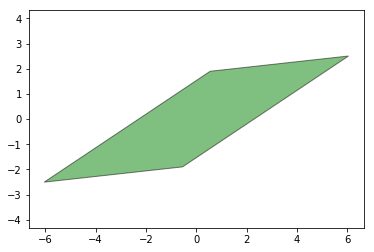

In [9]:
def max_pos_inv(A, S):
    maxIterations = 500
    # initialization
    Omega_i = S 
    for i in range(maxIterations):
        # compute backward reachable set
        P = precursor(Omega_i, A)
        # intersect with the state constraints
        P = pt.reduce(P).intersect(Omega_i)
        if P == Omega_i:
            Oinf = Omega_i
            break
        else:
            Omega_i = P
    if i == maxIterations:
        converged = 0
    else:
        converged = 1
    return Oinf, converged
 
# Maximal Invariant Set Computation
# first design a stabilizing control law:
Poles = np.array([0.1, 0.2])
# Poles = np.array([0.7, 0.8])
full_state_feedback = scipy.signal.place_poles(A, B, Poles)
K = full_state_feedback.gain_matrix
# closed loop system
Acl = A - B@K
# remember to convert input constraints in state constraints
S = X.intersect(pt.Polytope(U.A@ -K, U.b))
Oinf, converged = max_pos_inv(Acl,S)

fig, ax = plt.subplots()
Oinf.plot(ax, color='g', alpha=0.5, linestyle='solid', linewidth=1, edgecolor=None)
ax.autoscale_view()
ax.axis('equal')
plt.show()


Notice that the above code computes
the set $\mathcal{O}_\infty$ for system (1)
when it is controlled by $u=-Kx$, subject to the constraints (2).

Clearly the maximal positive invariant set $\mathcal{O}_\infty$ will be function of the feedback control law $K$.
As commented in the code, DO NOT forget
to convert input constraints in state constraints.


Try to change the control law $K$ in the algorithm above and interpret the results.
Try the controllers $\texttt{K=scipy.signal.place_poles(A,B,[0.7 0.8])}$ and $\texttt{K=scipy.signal.place_poles(A,B,[0.1 0.2])}$.

***

## 2.2 How to compute control invariant sets
A set $\mathcal{C}\subseteq \mathcal{X}$ is said to be a control invariant set if
\begin{align}
x(t)\in\mathcal{C} \quad \Rightarrow \quad
\exists u(t)\in\mathcal{U}~\textrm{such that}~  f(x(t),u(t))\in
    \mathcal{C},\quad \forall t\in\mathbb{N}^+
\end{align}

In class we introduced a simple algorithm for computing the
Maximal Control Invariant Set $\mathcal{C}_\infty$ (the largest control invariant):

1. LET $\Omega_{0}=\mathcal{X}$
2. LET $\Omega_{k+1}= \textbf{Pre}(A,B,\Omega_k)\cap\Omega_k$
3. IF $\Omega_{k+1}=\Omega_k$ THEN $\mathcal{C}_\infty\leftarrow\Omega_{k+1}$
4. ELSE GOTO 2


Below you find the implementation.

In [10]:
def max_cntr_inv(A,B,X,U):
    maxIterations = 500
    # initialization
    Omega0 = X 
    for i in range(maxIterations):
        # compute backward reachable set
        P = precursor(Omega0, A, U, B)
        # intersect with the state constraints
        P = pt.reduce(P).intersect(Omega0)
        if P == Omega0:
            Cinf = Omega0
            break
        else:
            Omega0 = P
    if i == maxIterations:
        converged = 0
    else:
        converged = 1
    return Cinf, converged

# Maximal Control Invariant Set Computation
Cinf, converged = max_cntr_inv(A, B, X, U)

The maximal control invariant set $\mathcal{C}_\infty$ does not depend on a specific feedback control law.
Try to compare $\mathcal{C}_\infty$ with the $\mathcal{O}_\infty$ sets compute before. Interpret the results.

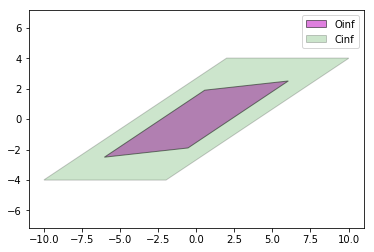

In [11]:
fig, ax = plt.subplots()
Oinf.plot(ax, color='m', alpha=0.5, linestyle='solid', linewidth=1, edgecolor=None)
Cinf.plot(ax, color='g', alpha=0.2, linestyle='solid', linewidth=1, edgecolor=None)
ax.autoscale_view()
ax.axis('equal')
ax.legend(['Oinf', 'Cinf'])
plt.show()

***

# <font color=blue> 3 Persistently Feasible and Stable MPC </font>

Consider the problem of regulating to the
origin the discrete-time linear time-invariant system
\begin{equation}
    x(t+1)=Ax(t)+Bu(t), \quad \quad \quad (11)
\end{equation}
where $x(t) \in \mathbb{R}^n$, $u(t)\in\mathbb{R}^{m}$ are the state and input
vectors, respectively, subject to the constraints
\begin{equation}
    x(t)\in\mathcal{X},~u(t)\in\mathcal{U},~\forall t\geq0,  \quad \quad (12)
\end{equation}
where the sets $\mathcal{X}\subseteq\mathbb{R}^n$ and $\mathcal{U}\subseteq\mathbb{R}^m$
are polyhedra.
MPC approaches such a constrained
regulation problem in the following way. Assume that a full measurement
or estimate of the state
$x(t)$ is available at the current time $t$. Then the finite time
optimal control problem

\begin{equation}
{ \begin{aligned}
     J_t^*(x(t))= & \min_{{U_{t->t+N|t}}} &\displaystyle{p(x_{t+N|t}) + \sum_{k=0}^{N-1}
q(x_{t+k|t},u_{t+k|t})} \\
     &\text{subject to} &  x_{t+k+1|t}=Ax_{t+k|t}+Bu_{t+k|t},\ k=0,\ldots,N-1\\
     &                &x_{t+k|t}\in\mathcal{X},~u_{t+k|t}\in\mathcal{U},\ k=0,\ldots,N-1\\
     &                & x_{t+N|t}\in {\mathcal{X}_f} \\
     &                & x_{t|t}=x(t)\\
     &                & &\quad \quad \quad  \quad(13)\\
  \end{aligned}
}
\end{equation}
is solved at time $t$, where
$U_{t->t+N|t}=\{u_{t|t},\ldots,u_{t+N-1|t}\}$ and
where $x_{t+k|t}$ denotes the state vector at time $t+k$ predicted at time $t$
obtained by starting from the current state $x_{t|t}=x(t)$ and applying to the system model

\begin{equation}
    x_{t+k+1|t}=Ax_{t+k|t}+Bu_{t+k|t}    
\end{equation}

the input sequence $u_{t|t},\ldots,u_{t+k-1|t}$.
Often the symbol $x_{t+k|t}$ is read as `the state $x$ at time $t+k$ predicted at time $t$`.
Similarly, $u_{t+k|t}$ is read as `the input $u$ at time $t+k$ computed at time $t$`.


Let $U_{t->t+N|t}^*=\{u^*_{t|t},\ldots,u^*_{t+N-1|t}\}$ be the optimal solution
of (13) at time $t$ and $J_t^*(x(t))$ the
corresponding value function. Then, the first element of $U_{t->t+N|t}^*$ is
applied to system (11)
\begin{equation}
    u(t)=u^*_{t|t}(x(t)).  \quad \quad (14)
\end{equation}
The optimization problem (13) is repeated at time $t+1$,
based on the new state $x_{t+1|t+1}=x(t+1)$, yielding a *moving* or
*receding horizon* control strategy.

Let $f_t:\mathbb{R}^n\rightarrow\mathbb{R}^m$ denote the *receding horizon* control law
that associates the optimal input $u^*_{t|t}$ to the current state $x(t)$,
$f_t(x(t))=u^*_{t|t}(x(t))$. Then the closed-loop system obtained by
controlling (11)
with the RHC (13)-(14) is
\begin{equation}
x(k+1)=Ax(k)+Bf_{k}(x(k)) \triangleq f_{cl}(x(k),k),\ k\geq0. \quad \quad (15)
\end{equation}


We also noticed that for linear time-invariant systems and time invariant cost and constraints, the control law (14)
\begin{equation}
    u(t)=f_0(x(t))=u^*_{0}(x(t)) \quad \quad (16)
\end{equation}
and closed-loop system (15)
\begin{equation}
x(k+1)=Ax(k)+Bf_{0}(x(k)) = f_{cl}(x(k)),\ k\geq0 \quad \quad \quad (17)
\end{equation}
are time-invariant.

***

## 3.1 MPC Main Theorem


In class we introduced the two concepts of

1. Persistent feasibility.
2. Asymptotic stability of the origin in a region called `domain of attraction`.


We also proved the following fundamental theorem:

Assume that

(A0) The stage cost $q(x,u)$ and terminal cost $p(x)$ are continuous and positive definite functions.

(A1) The sets $\mathcal{X}$, $\mathcal{X}_f$ and $\mathcal{U}$ contain  the origin in their interior and are closed.

(A2) $\mathcal{X}_f$ is control invariant, $\mathcal{X}_f\subseteq \mathcal{X}$.

(A3) $\displaystyle{\min_{v\in\mathcal{U},~Ax+Bv\in\mathcal{X}_f}} (-p(x)+q(x,v)+p(Ax+Bv)) \leq 0,~\forall x\in\mathcal{X}_f$.

Then,

1. the closed-loop system (17)
is persistently feasible in $\mathcal{X}_0$,
2. the origin of the closed-loop system (17)
is asymptotically stable with domain of attraction $\mathcal{X}_0$.


Assumptions A0 and A1 are standard.
We have shown that the simplest way to satisfy Assumptions
A2 and A3 is to pick $\mathcal{X}_f=0$ and any positive semi-definite terminal cost $p(x)=x'Px$. Next we are going to discuss other two options for selecting $\mathcal{X}_f$ and $p(x)$.

***

## 3.2 Using LQR
In this approach we design a stabilizing feedback controller for system (1) by using the infinite time, unconstrained linear quadratic regulator (LQR) $F_\infty$ with the same weights $Q$ and $R$ of the desired MPC tuning ($\texttt{Q=eye(2)}$ and $\texttt{R=1}$).

In [12]:
nx = np.size(A,0)  # number of states
nu = np.size(B,1)  # number of inputs

Q = np.eye(2)
R = np.array([1])

def dlqr(A, B, Q, R):
    # solve Discrete Algebraic Riccatti equation  
    P = scipy.linalg.solve_discrete_are(A, B, Q, R)

    # compute the LQR gain
    K = scipy.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)

    # stability check 
    eigVals, eigVecs = scipy.linalg.eig(A - B @ K)
    return K, P

Finf, Pinf = dlqr(A, B, Q, R)


Then we follow the approach of Section 2.1 to compute the maximal positive invariant set $\mathcal{O}_\infty$ for system (1) when controlled by the LQR controller $u=-F_\infty x$, subject to the constraints (2).

In [13]:
# closed loop system
Acl = A - B@Finf

# remeber to convet input constraits in state constraints
S = X.intersect(pt.Polytope(U.A@ -Finf, U.b))
Oinf, converged = max_pos_inv(Acl,S)

Finally, in the CFTOC problem (13) solved by the MPC at each step we use  $\mathcal{X}_f=\mathcal{O}_\infty$ and $p(x)=x'P_\infty x$ where $P_\infty$ is LQR the infinite time cost. With this choice we satisfy assumption $A2$ (immediate to prove) and assumption $A3$  (proof next).

In [14]:
# Compute the set of initial feasible states form MPC
N = 3

Kc = {}
PreS = precursor(Oinf, A, U, B)   # Note that 
for j in range(N):
    Kc[j]= PreS.intersect(X)
    PreS = precursor(Kc[j], A, U, B)
    
X0 = Kc[N-1]  # The initial feasible set X0 is equivalent to the N-step controllable set. 

***

## Simulation with MPC

In [15]:
# Setup the CFTOC

import pyomo.environ as pyo

Xf = Oinf
Af = Xf.A
bf = Xf.b

Q = np.eye(2)
R = np.array([1]).reshape(1,1)
P = Pinf
N = 3
x0 = np.array([-6, -3])


def solve_cftoc(A, B, P, Q, R, N, x0, x1U, x2U, uL, uU, bf, Af):
    
    model = pyo.ConcreteModel()
    model.N = N
    model.nx = np.size(A, 0)
    model.nu = np.size(B, 1)
    model.nf = np.size(Af, 0)
    
    # length of finite optimization problem:
    model.tIDX = pyo.Set( initialize= range(model.N+1), ordered=True )  
    model.xIDX = pyo.Set( initialize= range(model.nx), ordered=True )
    model.uIDX = pyo.Set( initialize= range(model.nu), ordered=True )
    
    model.nfIDX = pyo.Set( initialize= range(model.nf), ordered=True )
    
    # these are 2d arrays:
    model.A = A
    model.B = B
    model.Q = Q
    model.P = P
    model.R = R
    model.Af = Af
    model.bf = bf
    
    # Create state and input variables trajectory:
    model.x = pyo.Var(model.xIDX, model.tIDX)
    model.u = pyo.Var(model.uIDX, model.tIDX, bounds=(uL,uU))
    
    #Objective:
    def objective_rule(model):
        costX = 0.0
        costU = 0.0
        costTerminal = 0.0
        for t in model.tIDX:
            for i in model.xIDX:
                for j in model.xIDX:
                    if t < model.N:
                        costX += model.x[i, t] * model.Q[i, j] * model.x[j, t] 
        for t in model.tIDX:
            for i in model.uIDX:
                for j in model.uIDX:
                    if t < model.N:
                        costU += model.u[i, t] * model.R[i, j] * model.u[j, t]
        for i in model.xIDX:
            for j in model.xIDX:               
                costTerminal += model.x[i, model.N] * model.P[i, j] * model.x[j, model.N]
        return costX + costU + costTerminal
    
    model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)
    
    # Constraints:
    def equality_const_rule(model, i, t):
        return model.x[i, t+1] - (sum(model.A[i, j] * model.x[j, t] for j in model.xIDX)
                               +  sum(model.B[i, j] * model.u[j, t] for j in model.uIDX) ) == 0.0 if t < model.N else pyo.Constraint.Skip
    

    model.equality_constraints = pyo.Constraint(model.xIDX, model.tIDX, rule=equality_const_rule)
    model.init_const1 = pyo.Constraint(expr = model.x[0, 0] == x0[0])
    model.init_const2 = pyo.Constraint(expr = model.x[1, 0] == x0[1])
    model.state_limit1 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[0, t] <= x1U
                                   if t < N else pyo.Constraint.Skip)
    model.state_limit2 = pyo.Constraint(model.tIDX, rule=lambda model, t: -x1U <= model.x[0, t]
                                    if t < N else pyo.Constraint.Skip)
    model.state_limit3 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[1, t] <= x2U
                                   if t < N else pyo.Constraint.Skip)
    model.state_limit4 = pyo.Constraint(model.tIDX, rule=lambda model, t: -x2U <= model.x[1, t]
                                    if t < N else pyo.Constraint.Skip)
    
    def final_const_rule(model, i):
        return sum(model.Af[i, j] * model.x[j, model.N] for j in model.xIDX) <= model.bf[i] 
    
    model.final_const = pyo.Constraint(model.nfIDX, rule=final_const_rule)
    
    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)
    
    if str(results.solver.termination_condition) == "optimal":
        feas = True
    else:
        feas = False
            
    xOpt = np.asarray([[model.x[i,t]() for i in model.xIDX] for t in model.tIDX]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T
    
    JOpt = model.cost()
      
    return [model, feas, xOpt, uOpt, JOpt]

[model, feas, xOpt, uOpt, JOpt] = solve_cftoc(A, B, P, Q, R, N, x0, x1U, x2U, -uU, uU, bf, Af)

(-6.301607190581559,
 0.3337510022127465,
 -3.154567753510574,
 0.24592282372205504)

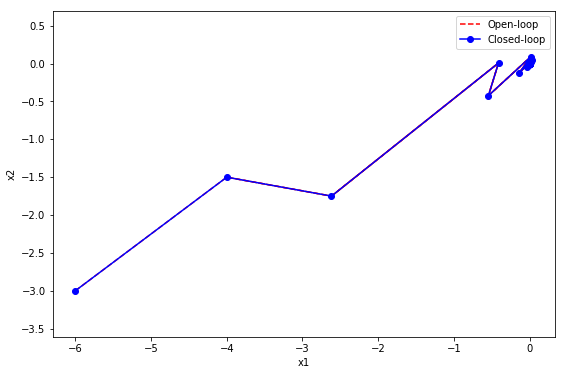

In [16]:
# Run closed loop with MPC

# Setup the simulation with MPC controller

nx = np.size(A, 0)
nu = np.size(B, 1)

M = 25   # Simulation steps
xOpt = np.zeros((nx, M+1))
uOpt = np.zeros((nu, M))
xOpt[:, 0] = x0.reshape(nx, )

xPred = np.zeros((nx, N+1, M))
predErr = np.zeros((nx, M-N+1))

feas = np.zeros((M, ), dtype=bool)
xN = np.zeros((nx,1))

fig = plt.figure(figsize=(9, 6))
for t in range(M):
    [model, feas[t], x, u, J] = solve_cftoc(A, B, P, Q, R, N, xOpt[:, t], x1U, x2U, -uU, uU, bf, Af)
    
    if not feas[t]:
        xOpt = []
        uOpt = []
        predErr = []
        break
    # Save open loop predictions
    xPred[:, :, t] = x

    # Save closed loop trajectory
    # Note that the second column of x represents the optimal closed loop state
    xOpt[:, t+1] = x[:, 1]
    uOpt[:, t] = u[:, 0].reshape(nu, )

    # Plot Open Loop
    line1 = plt.plot(x[0,:], x[1,:], 'r--')

# Plot Closed Loop
line2 = plt.plot(xOpt[0, :], xOpt[1, :], 'bo-')
plt.legend([line1[0], line2[0]], ['Open-loop', 'Closed-loop']);
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')

***

## Why with this design Assumption A3 is satisfied?

Since the control law is fixed, Assumption A3 becomes
\begin{equation}
-x'P_\infty x+ x'Qx+x'F_\infty' RF_\infty x+(Ax-BF_\infty x)'P_\infty (Ax-BF_\infty x)..
 \leq 0,~\forall x\in\mathcal{X}_f
\end{equation}
which can be rewritten as:
\begin{align}
x'(-P_\infty+Q+F_\infty' (B'P_\infty B+R) F_\infty +A'P_\infty A-2F_\infty' B'P_\infty A )x
 \leq 0,~\forall x\in\mathcal{X}_f.
\end{align}
Recall from LQR that
\begin{align}
F_\infty=(B'P_\infty B+R)^{-1}B'P_\infty A.
\end{align}
Therefore Assumption A3 becomes
\begin{equation}
\begin{aligned}
x'(-P_\infty+Q+A'P_\infty B (B'P_\infty B+R)^{-1} (B'P_\infty B+R)(B'P_\infty B+R)^{-1}B'P_\infty A+\\
+ A'P_\infty A-2A'P_\infty B(B'P_\infty B+R)^{-1}B'P_\infty A   )x  \leq 0,~\forall x\in\mathcal{X}_f,
\end{aligned}
\end{equation}
which can be simplified to
\begin{align}
x'(-P_\infty+Q+A'P_\infty A-A'(P_\infty B(B'P_\infty B+R)^{-1}BP_\infty)A)x  \leq 0,\ \forall x\in \mathcal{X}_f.
\end{align}
Note that the LQR cost $P_\infty$ solves the Riccati Equation:
\begin{equation}
P_\infty = A'P_\infty A + Q - A'P_\infty B(B'P_\infty B + R)^{-1} B' P_\infty A. 
\end{equation}
Therefore we proved that
\begin{align}
x'(-P_\infty+Q+A'P_\infty A-A'(P_\infty B(B'P_\infty B+R)^{-1}BP_\infty)A)x  = 0,\ \forall x\in \mathcal{X}_f.
\end{align}


***

## 3.3  Using any stabilizing controller
In general, instead of $F_\infty$ we can choose any controller $F$ which stabilizes $A+BF$. For instance one could use a pole placement control design.

With $v=Fx$ the assumption (A3) in the main MPC Theorem becomes
\begin{equation}
-P+ (Q+F'RF)+(A+BF)'P(A+BF)  \leq 0.
\label{eq:ch13_1235}
\end{equation}
It is satisfied as an equality if we choose $P$ as a solution of the corresponding Lyapunov equation.

In [17]:
# first design a stabilizing control law via pole placement


Poles = np.array([0.1, 0.2])
full_state_feedback = scipy.signal.place_poles(A, B, Poles)
K = full_state_feedback.gain_matrix
# closed loop system
Acl = A - B@K
# remember to convert input constraints in state constraints
S = X.intersect(pt.Polytope(U.A@ -K, U.b))
# terminal set
Oinf, converged = max_pos_inv(Acl,S)
# terminal cost
P_terminal = scipy.linalg.solve_discrete_lyapunov(Acl, Q+K.T@R@K)


If the open loop system (11) is asymptotically stable, then we may even select $F=0$. Note that depending on the choice of the controller the controlled invariant terminal region $\mathcal{X}_f$ changes.